In [1]:
import pandas as pd
import numpy as np

import gensim
import nltk
nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt

import ast

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss

from joblib import dump, load

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## In this notebook, I will create two different logistic regression models to predict genre of songs. These will be used for baseline comparisons with the LSTM and HAN models.

In [4]:
log_reg_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/train_full_cleaned_data.csv')

In [5]:
log_reg_data

,Unnamed: 0,Artist,Song,Genre,Language,Lyrics
0,0,1 800 zombie,unicorn,Electronic,en,"Don't call me horse. I'm a unicorn. Mystical, ..."
1,1,10 cc,lazy days,Rock,en,Hazy Days With Lazy Ways You get less done but...
2,2,10 cc,memories,Rock,en,"The summers were longer, they went on forever ..."
3,3,10 cc,now you re gone,Rock,en,You promised me a life You promised me everyth...
4,4,10 cc,sand in my face,Rock,en,I looked in the mirror (What did you see looki...
...,...,...,...,...,...,...
203669,203669,zz top,whiskey'n mama,Rock,en,"I'm so tired, you on my head.\nWhiskey'n mama,..."
203670,203670,zz top,woke up with wood,Rock,en,When I woke up this morning\nI was feeling mig...
203671,203671,zz top,world of swirl,Rock,en,"I hit the street running, had an angle in mind..."
203672,203672,zz top,your legs are as hairy as my beard,Rock,en,I've got a beard\nAnd it is long\nAnd you've g...


In [6]:
log_reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203674 entries, 0 to 203673
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  203674 non-null  int64 
 1   Artist      203674 non-null  object
 2   Song        203674 non-null  object
 3   Genre       203674 non-null  object
 4   Language    203674 non-null  object
 5   Lyrics      203671 non-null  object
dtypes: int64(1), object(5)
memory usage: 9.3+ MB


### 1) Training a Word2Vec model

#### I will be training the word2vec model on the entire corpus

#### a. split each set of lyrics from a string into many lists, where each list is a sentence

In [6]:
lyric_lists = []
for song in log_reg_data['Lyrics']:
    if isinstance(song, str):
        lyric_lists.append(song.splitlines())
    else:
        lyric_lists.append([])

log_reg_data['Lyrics as Lists'] = lyric_lists
log_reg_data.head(2)

,Unnamed: 0,Artist,Song,Genre,Language,Lyrics,Lyrics as Lists
0,0,1 800 zombie,unicorn,Electronic,en,"Don't call me horse. I'm a unicorn. Mystical, ...","[Don't call me horse. I'm a unicorn. Mystical,..."
1,1,10 cc,lazy days,Rock,en,Hazy Days With Lazy Ways You get less done but...,[Hazy Days With Lazy Ways You get less done bu...


In [ ]:
log_reg_data['Lyrics'][24000]

'Oh, angels sent from up above\nYou know you make my world light up\nWhen I was down, when I was hurt\nYou came to lift me up\nLife is a drink, and love\'s a drug\nOh now I think I must be miles up\nWhen I was a river dried up\nYou came to rain a flood\nAnd said "drink from me, drink from me"\nWhen I was so thirsty\nWe\'re on a symphony\nNow I just can\'t get enough\nPut your wings on me, wings on me\nWhen I was so heavy\nWe\'re on a symphony\nWhen I\'m low, low, low, low\nI-oh-I-oh-I\nGot me feeling drunk and high\nSo high, so high\nOh-I-oh-I-oh-I\nNow I\'m feeling drunk and high\nSo high, so high\n(Woo)\n(Woo-oo-oo-woo)\nOh, angels sent from up above\nI feel it coursing through my blood\nLife is a drink, your love\'s about\nTo make the stars come out\nPut your wings on me, wings on me\nWhen I was so heavy\nWe\'re on a symphony\nWhen I\'m lower, lower, lower, low\nGot me feeling drunk and high\nSo high, so high\nOh-ah-oh-ah-oh-ah\nI\'m feeling drunk and high\nSo high, so high\nAh-oh-a

In [ ]:
log_reg_data['Lyrics as Lists'][24000]

['Oh, angels sent from up above',
 'You know you make my world light up',
 'When I was down, when I was hurt',
 'You came to lift me up',
 "Life is a drink, and love's a drug",
 'Oh now I think I must be miles up',
 'When I was a river dried up',
 'You came to rain a flood',
 'And said "drink from me, drink from me"',
 'When I was so thirsty',
 "We're on a symphony",
 "Now I just can't get enough",
 'Put your wings on me, wings on me',
 'When I was so heavy',
 "We're on a symphony",
 "When I'm low, low, low, low",
 'I-oh-I-oh-I',
 'Got me feeling drunk and high',
 'So high, so high',
 'Oh-I-oh-I-oh-I',
 "Now I'm feeling drunk and high",
 'So high, so high',
 '(Woo)',
 '(Woo-oo-oo-woo)',
 'Oh, angels sent from up above',
 'I feel it coursing through my blood',
 "Life is a drink, your love's about",
 'To make the stars come out',
 'Put your wings on me, wings on me',
 'When I was so heavy',
 "We're on a symphony",
 "When I'm lower, lower, lower, low",
 'Got me feeling drunk and high',
 '

In [ ]:
full_lyrics = log_reg_data['Lyrics as Lists']

#### b. tokenize lyrics, then train Word2Vec

In [ ]:
full_tokenized_lines = [word_tokenize(line.lower()) for lines_list in full_lyrics for line in lines_list]

In [ ]:
# save off the tokenization because it took forever to do and used up all my RAM
file_path = "/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/full_tokenized_lines.txt"

with open(file_path, "w") as file:
    for item in full_tokenized_lines:
        file.write(f"{item}\n")

In [ ]:
# now load it back in after restarting session
full_tokenized_lines = []

file_path = "/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/full_tokenized_lines.txt"

with open(file_path, "r") as file:
    for line in file:
        tokens = ast.literal_eval(line.strip())
        full_tokenized_lines.append(tokens)

In [ ]:
#full_tokenized_lines

In [ ]:
# parameters
vector_size = 100
window_size = 10
min_count = 1
workers = 4

In [ ]:
model_w2v = Word2Vec(sentences=full_tokenized_lines, vector_size=vector_size, window=window_size, min_count=min_count, workers=workers)
model_path = "/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/word_two_vec_model.model"
model_w2v.save(model_path)

In [7]:
# load model back in. save my ram.
model_path = "/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/word_two_vec_model.model"
model_w2v = Word2Vec.load(model_path)

### 2) Logistic Regression Model

#### a. Process training data by splitting into train/validation split and tokenizing

In [8]:
log_reg_data_subset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/train_clean_w_sentiment.csv')

In [9]:
lyric_lists = [song.splitlines() for song in log_reg_data_subset['Lyrics']]
log_reg_data_subset['Lyrics as Lists'] = lyric_lists
log_reg_data_subset.head(2)

,Unnamed: 0.1,Unnamed: 0,Artist,Song,Genre,Language,Lyrics,Sentiment,Lyrics as Lists
0,0,78168,franz ferdinand,swallow smile,Rock,en,I rise and curse the waking day\nCurse the gri...,0,"[I rise and curse the waking day, Curse the gr..."
1,1,155890,ry cooder,big bad bill is sweet william now,Rock,en,In the town of Louisville they got a man they ...,-1,[In the town of Louisville they got a man they...


In [11]:
log_reg_data_subset['Lyrics as Lists'][24]

["I don't want to die",
 'Even though I have to',
 'I just want to live a long, long time',
 'And I see the gang to which I belong',
 'Time to sing out our happy song',
 "Wouldn't it be a cruel joke",
 "If it's too late to try? Why?",
 "I don't wanna grow",
 "Even if it's good growth",
 'I just wanna stay just like this',
 'And I see the comfortable place to rest',
 'Time to get this $^@! off my chest',
 "Wouldn't it be a cruel joke",
 "If it's too late to try? Why?."]

In [10]:
# stratify so it doesn't just grab a couple of the genres. it needs to sample from all the genres
train_lr, val_lr = train_test_split(log_reg_data_subset, test_size=0.2, random_state=24, stratify = log_reg_data_subset['Genre'])

In [11]:
print(train_lr['Genre'].value_counts())
print(val_lr['Genre'].value_counts())

Metal         1200
Folk          1200
Country       1200
Hip-Hop       1200
Rock          1200
Jazz          1200
Electronic    1200
Pop           1200
Indie         1200
R&B           1200
Name: Genre, dtype: int64
Hip-Hop       300
Country       300
Pop           300
Folk          300
R&B           300
Jazz          300
Rock          300
Electronic    300
Indie         300
Metal         300
Name: Genre, dtype: int64


In [12]:
#train_tokenized_lines = [word_tokenize(line.lower()) for lines_list in train_lyrics for line in lines_list]

#### b. apply the word2vec model to create line-level embeddings

In [11]:
def lyrics_to_embeddings(lines, model):
    tokenized_lines = [word_tokenize(line.lower()) for line in lines]
    embeddings = [model.wv[word] for line in tokenized_lines for word in line if word in model.wv.key_to_index]
    return embeddings

In [12]:
train_lr['Embeddings'] = train_lr['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))
val_lr['Embeddings'] = val_lr['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))

#### c. Method 1 - Take an average of sentence-level embeddings (word2vec) to create document representation

Create the embeddings

In [47]:
train_lr['WholeSongEmbedding'] = train_lr['Embeddings'].apply(lambda x: np.mean(x, axis=0))
val_lr['WholeSongEmbedding'] = val_lr['Embeddings'].apply(lambda x: np.mean(x, axis=0))

In [48]:
train_lr['WholeSongEmbedding'] = train_lr['WholeSongEmbedding'].apply(lambda x: np.array(x))
val_lr['WholeSongEmbedding'] = val_lr['WholeSongEmbedding'].apply(lambda x: np.array(x))

In [49]:
train_lr

,Unnamed: 0.1,Unnamed: 0,Artist,Song,Genre,Language,Lyrics,Sentiment,Lyrics as Lists,Embeddings,WholeSongEmbedding
3296,3296,36771,bring me the horizon,follow you,Metal,en,My head is haunting me\nand my heart feels lik...,0,"[[my, head, is, haunting, me], [and, my, heart...","[[0.4999708, -2.8740227, -2.7737296, 2.1981041...","[0.3175378, 0.011641293, 0.21799603, 0.9877826..."
9887,9887,45221,christine lavin,yonder blue,Folk,en,"I see on the news, it's raining in London\nFor...",-1,"[[i, see, on, the, news, ,, it, 's, raining, i...","[[0.8601873, 1.110692, 0.40747494, 2.2764633, ...","[-0.13224815, 0.12381727, -0.22906983, 0.65795..."
9430,9430,125541,merle travis,i am a pilgrim,Folk,en,I am a pilgrim and a stranger\nTraveling throu...,0,"[[i, am, a, pilgrim, and, a, stranger], [trave...","[[0.8601873, 1.110692, 0.40747494, 2.2764633, ...","[-0.2623678, -0.2643544, 0.19002192, 0.6504381..."
10679,10679,79553,garth brooks,go tell it on the mountain,Country,en,Go tell it on the mountain Over the hills and ...,-1,"[[go, tell, it, on, the, mountain, over, the, ...","[[0.9736778, -0.21759444, 1.0776666, 1.4186223...","[-0.47125798, -0.16520126, 0.11660605, 0.09575..."
8578,8578,76696,flosstradamus,ttu too turnt up,Hip-Hop,en,Turnt up! I be divin' in the crowd Shake my dr...,-3,"[[turnt, up, !, i, be, divin, ', in, the, crow...","[[-0.98938644, 0.034332927, 0.78381515, 0.8231...","[-0.4287797, -0.15420355, 0.93094146, -0.02014..."
...,...,...,...,...,...,...,...,...,...,...,...
5436,5436,74696,fats waller,i love to whistle,Jazz,en,I love to whistle cause it makes me merry \nMa...,2,"[[i, love, to, whistle, cause, it, makes, me, ...","[[0.8601873, 1.110692, 0.40747494, 2.2764633, ...","[-0.011370993, 0.59951687, 0.40177378, 0.50757..."
5238,5238,33268,bobby mcferrin,blackbird,Jazz,en,Blackbird singing in the dead of night Take th...,-2,"[[blackbird, singing, in, the, dead, of, night...","[[-1.1094031, -0.22685087, -1.6450253, 0.27050...","[-0.039776187, -0.071232475, 0.021214243, 0.89..."
14331,14331,36295,brian mcknight,adeste fideles,R&B,en,"O come, all ye faithful Joyful and triumphant ...",3,"[[o, come, ,, all, ye, faithful, joyful, and, ...","[[1.371967, -0.98270184, -0.6979353, -0.267798...","[0.036608897, -0.3393107, -0.76927316, 0.01530..."
6397,6397,106182,karol conka,back to black,Indie,en,He left no time to regret\nKept his dick wet\n...,-1,"[[he, left, no, time, to, regret], [kept, his,...","[[-4.201377, -0.683052, 0.72411686, 2.5549479,...","[-0.14400828, 0.40603516, 0.4601209, 0.5294900..."


In [ ]:
train_lr.iloc[150]

Unnamed: 0.1                                                       4344
Unnamed: 0                                                       189226
Artist                                               theatre of tragedy
Song                                                              radio
Genre                                                             Metal
Language                                                             en
Lyrics                Electric broadcast\nThe new transmission waves...
Sentiment                                                            -1
Lyrics as Lists       [Electric broadcast, The new transmission wave...
Embeddings            [[-0.6277848, 1.3694221, -0.9837525, 1.1447902...
WholeSongEmbedding    [-0.09213081, 0.3771081, -0.06441679, 0.984508...
Name: 4344, dtype: object

Train the model

In [50]:
X_train = np.vstack(train_lr['WholeSongEmbedding'].apply(lambda x: x[0]))
y_train = train_lr['Genre']
print(X_train)
X_val = np.vstack(val_lr['WholeSongEmbedding'].apply(lambda x: x[0]))
y_val = val_lr['Genre']

print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

#standardization (is this necessary here?)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

[[ 0.31753781]
 [-0.13224815]
 [-0.26236781]
 ...
 [ 0.0366089 ]
 [-0.14400828]
 [-0.39682189]]
12000
3000
12000
3000


In [51]:
model_log_reg_avg = LogisticRegression(max_iter=10000)
model_log_reg_avg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

Evaluate

In [52]:
y_val_pred = model_log_reg_avg.predict(X_val)

In [53]:
accuracy_val = accuracy_score(y_val, y_val_pred)
classification_report_val = classification_report(y_val, y_val_pred)

print("Validation Accuracy:", accuracy_val)
print("Validation Classification Report:\n", classification_report_val)

Validation Accuracy: 0.129
Validation Classification Report:
               precision    recall  f1-score   support

     Country       0.07      0.02      0.03       300
  Electronic       0.07      0.02      0.04       300
        Folk       0.14      0.55      0.22       300
     Hip-Hop       0.13      0.04      0.06       300
       Indie       0.10      0.03      0.05       300
        Jazz       0.02      0.00      0.01       300
       Metal       0.03      0.01      0.01       300
         Pop       0.13      0.05      0.07       300
         R&B       0.14      0.55      0.22       300
        Rock       0.08      0.02      0.03       300

    accuracy                           0.13      3000
   macro avg       0.09      0.13      0.07      3000
weighted avg       0.09      0.13      0.07      3000



In [54]:
class_indices = model_log_reg_avg.classes_
class_indices

array(['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock'], dtype=object)

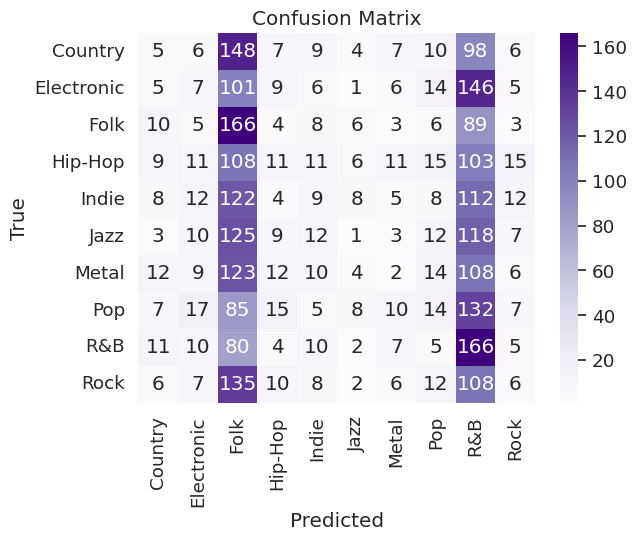

In [55]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Pop', 'R&B', 'Rock']

cm = confusion_matrix(y_val, y_val_pred, labels = genre_names)

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels= genre_names, yticklabels=genre_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### d. Method 2 - Use TF-IDF weightings of sentence-level embeddings (word2vec) to create document representation

Create the embeddings

In [13]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_lr['Lyrics'])
tfidf_matrix_val = tfidf_vectorizer.transform(val_lr['Lyrics'])

Train the Model

In [14]:
X_train = np.column_stack([tfidf_matrix_train.toarray(), np.vstack(train_lr['Embeddings'].apply(lambda x: np.mean(x, axis=0)))])
X_val = np.column_stack([tfidf_matrix_val.toarray(), np.vstack(val_lr['Embeddings'].apply(lambda x: np.mean(x, axis=0)))])

y_train = train_lr['Genre']
y_val = val_lr['Genre']

print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

#standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

12000
3000
12000
3000


In [ ]:
loss_test = []
for each in range(0,11):
  model_log_reg_tfidf = LogisticRegression(max_iter=each)
  model_log_reg_tfidf.fit(X_train, y_train)
  loss = log_loss(y_val, model_log_reg_tfidf.predict_proba(X_val), eps=1e-15)
  loss_test.append(loss)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
loss_test

[2.02402954560813,
 2.02402954560813,
 1.9880761732712233,
 2.142128662144312,
 2.442672045825868,
 2.9677403305885766,
 3.1510152095899526,
 3.360337715937358,
 3.6718745640115844,
 3.88368998584539,
 4.507742063166819]

In [15]:
model_log_reg_tfidf = LogisticRegression(max_iter=2)
model_log_reg_tfidf.fit(X_train, y_train)

LogisticRegression(max_iter=2)

In [ ]:
# loss for 20 epochs
loss = log_loss(y_val, model_log_reg_tfidf.predict_proba(X_val), eps=1e-15)
loss

5.638692177285072

In [ ]:
# loss for 100 epochs
loss = log_loss(y_val, model_log_reg_tfidf.predict_proba(X_val), eps=1e-15)
loss

5.25966534376009

In [ ]:
# loss for 200 epochs
loss = log_loss(y_val, model_log_reg_tfidf.predict_proba(X_val), eps=1e-15)
loss

4.948964804871198

In [ ]:
model_log_reg_tfidf_500 = LogisticRegression(max_iter=500)
model_log_reg_tfidf_500.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

In [ ]:
# loss for 500 epochs
loss = log_loss(y_val, model_log_reg_tfidf_500.predict_proba(X_val), eps=1e-15)
loss

4.889976559864925

In [ ]:
model_log_reg_tfidf_1000 = LogisticRegression(max_iter=1000)
model_log_reg_tfidf_1000.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [ ]:
# loss for 1000 epochs
loss = log_loss(y_val, model_log_reg_tfidf_1000.predict_proba(X_val), eps=1e-15)
loss

4.891260924480478

In [ ]:
model_log_reg_tfidf_2000 = LogisticRegression(max_iter=2000)
model_log_reg_tfidf_2000.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [ ]:
# loss for 2000 epochs
loss = log_loss(y_val, model_log_reg_tfidf_2000.predict_proba(X_val), eps=1e-15)
loss

4.891240165329839

Evaluate the best one (lowest validation loss) --> 2 epochs

In [16]:
y_val_pred = model_log_reg_tfidf.predict(X_val)

In [17]:
accuracy_val = accuracy_score(y_val, y_val_pred)
classification_report_val = classification_report(y_val, y_val_pred)

print("Validation Accuracy:", accuracy_val)
print("Validation Classification Report:\n", classification_report_val)

Validation Accuracy: 0.36333333333333334
Validation Classification Report:
               precision    recall  f1-score   support

     Country       0.40      0.47      0.43       300
  Electronic       0.30      0.22      0.25       300
        Folk       0.32      0.29      0.31       300
     Hip-Hop       0.47      0.79      0.59       300
       Indie       0.27      0.16      0.20       300
        Jazz       0.44      0.54      0.48       300
       Metal       0.46      0.62      0.53       300
         Pop       0.22      0.12      0.16       300
         R&B       0.26      0.37      0.30       300
        Rock       0.17      0.06      0.09       300

    accuracy                           0.36      3000
   macro avg       0.33      0.36      0.33      3000
weighted avg       0.33      0.36      0.33      3000



In [21]:
class_indices = model_log_reg_tfidf
class_indices

LogisticRegression(max_iter=2)

In [22]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']

cm = confusion_matrix(y_val, y_val_pred, labels=genre_names)

Create a finalized visualization for the report and save it as a png

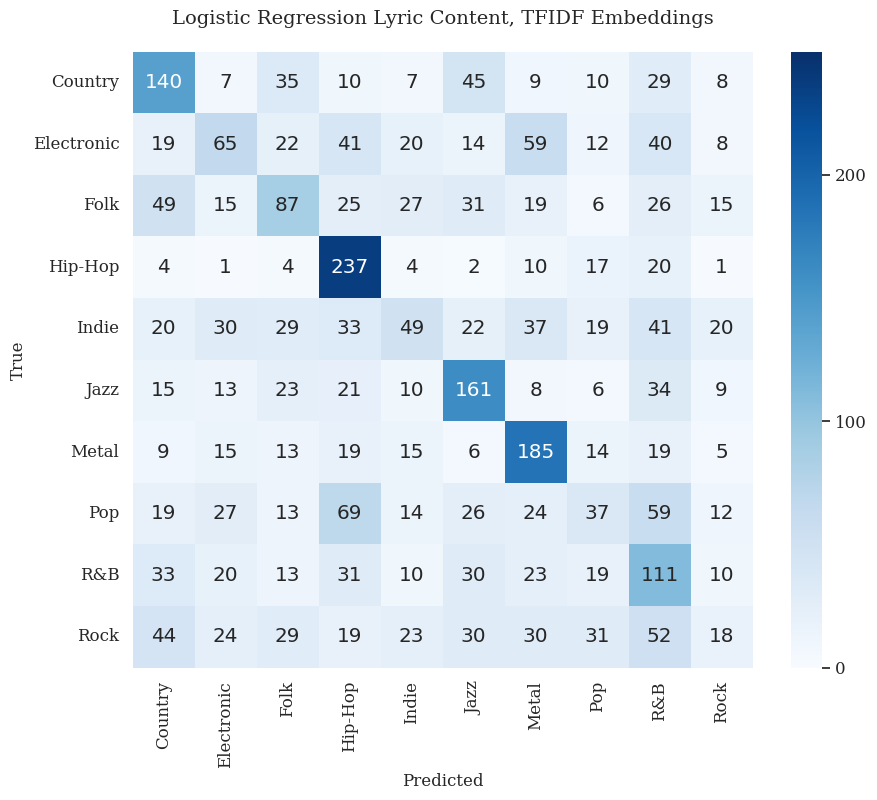

In [34]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(cm, annot=True,fmt='d',cmap='Blues',xticklabels=genre_names,yticklabels=genre_names,vmin=0,
    vmax=250,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)

cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.set_major_locator(MultipleLocator(100))

for label in cbar.ax.yaxis.get_ticklabels():
    label.set_fontname('Serif')
    label.set_fontsize(12)

plt.xlabel('Predicted', fontsize=12, fontfamily='Serif')
plt.ylabel('True', fontsize=12, fontfamily='Serif')
plt.title('Logistic Regression Lyric Content, TFIDF Embeddings', fontsize=14, fontfamily='Serif', pad = 20)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/log_reg_content_tfidf.png', bbox_inches='tight')

save the model for use in ensemble models

In [ ]:
dump(model_log_reg_tfidf, '/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_log_reg_content.joblib')

['/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_log_reg_content.joblib']